# Long Document Understanding with Qwen3-VL (Together AI)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Multimodal/Vision/Long_Document_Understanding.ipynb)


## Introduction

In this notebook, we'll explore Qwen3-VL's ability to understand long documents with multiple pages using Together AI's API. We'll cover:

1. Converting PDFs to images
2. Sending multiple images in a single request
3. Answering questions across all pages

**Token Limits:** Together AI calculates image tokens as `T = min(2, max(H // 560, 1)) * min(2, max(W // 560, 1)) * 1601`, resulting in ~1,601 to 6,404 tokens per image.


### Install required libraries


In [2]:
!pip install openai pillow pdf2image requests


  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
Using cached pdf2image-1.17.0-py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


**Note:** You also need to install poppler for PDF conversion:
- Ubuntu/Debian: `sudo apt install poppler-utils`
- macOS: `brew install poppler`
- Windows: Download from https://github.com/oschwartz10612/poppler-windows


In [3]:
import os
import math
import hashlib
import base64
import requests
import openai
import numpy as np
from io import BytesIO
from PIL import Image
from pdf2image import convert_from_path
from IPython.display import Markdown, display

# Add Homebrew to PATH for poppler
if os.path.exists("/opt/homebrew/bin"):
    os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

# Together AI Configuration
client = openai.OpenAI(
    api_key=os.environ.get("TOGETHER_API_KEY"),
    base_url="https://api.together.xyz/v1",
)

MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct"

print(f"Using model: {MODEL_ID}")
print(f"API Key configured: {bool(os.environ.get('TOGETHER_API_KEY'))}")


Using model: Qwen/Qwen3-VL-32B-Instruct
API Key configured: True


In [4]:
# Utility functions

def download_file(url, dest_path):
    """Download a file from URL."""
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"File downloaded to {dest_path}")


def get_pdf_images(pdf_path, dpi=144, cache_dir='cache', max_pages=None):
    """Convert PDF to list of PIL images."""
    os.makedirs(cache_dir, exist_ok=True)
    
    pdf_hash = hashlib.md5(pdf_path.encode('utf-8')).hexdigest()
    
    # Handle URL
    if pdf_path.startswith('http://') or pdf_path.startswith('https://'):
        pdf_file_path = os.path.join(cache_dir, f'{pdf_hash}.pdf')
        if not os.path.exists(pdf_file_path):
            download_file(pdf_path, pdf_file_path)
        else:
            print(f"Using cached PDF: {pdf_file_path}")
    else:
        pdf_file_path = pdf_path

    # Check for cached images
    cache_key = f'{pdf_hash}_{dpi}'
    if max_pages:
        cache_key += f'_{max_pages}'
    images_cache_file = os.path.join(cache_dir, f'{cache_key}_images.npy')
    
    if os.path.exists(images_cache_file):
        images = np.load(images_cache_file, allow_pickle=True)
        pil_images = [Image.fromarray(image) for image in images]
        print(f"Loaded {len(pil_images)} pages from cache")
        return pil_images

    # Convert PDF to images
    print(f"Converting PDF to images at {dpi} DPI...")
    pil_images = convert_from_path(pdf_file_path, dpi=dpi)
    
    if max_pages:
        pil_images = pil_images[:max_pages]
    
    # Resize large images
    resized_images = []
    max_side_value = 1500
    for img in pil_images:
        width, height = img.size
        max_side = max(width, height)
        if max_side > max_side_value:
            img = img.resize((width * max_side_value // max_side, height * max_side_value // max_side))
        resized_images.append(img)
    
    # Cache images
    images_array = [np.array(img) for img in resized_images]
    np.save(images_cache_file, images_array)
    print(f"Converted and cached {len(resized_images)} pages")
    
    return resized_images


def pil_to_base64(pil_image, format="PNG"):
    """Convert PIL Image to base64."""
    buffer = BytesIO()
    pil_image.save(buffer, format=format)
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


def create_image_grid(pil_images, num_columns=8):
    """Create a grid of thumbnail images."""
    if not pil_images:
        return None
    
    num_rows = math.ceil(len(pil_images) / num_columns)
    img_width, img_height = pil_images[0].size
    
    # Create smaller thumbnails for grid
    thumb_width = img_width // 4
    thumb_height = img_height // 4
    
    grid_width = num_columns * thumb_width
    grid_height = num_rows * thumb_height
    grid_image = Image.new('RGB', (grid_width, grid_height), 'white')

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * thumb_width, row_idx * thumb_height)
        thumbnail = image.copy()
        thumbnail.thumbnail((thumb_width, thumb_height))
        grid_image.paste(thumbnail, position)

    return grid_image


def inference_with_images(images, prompt, max_tokens=4096):
    """Run inference with multiple images."""
    print(f"Sending {len(images)} pages to the model...")
    
    content = []
    for img in images:
        base64_img = pil_to_base64(img)
        content.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{base64_img}"}
        })
    content.append({"type": "text", "text": prompt})
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[{"role": "user", "content": content}],
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content


## Example: Analyzing an Academic PDF

Load a PDF document and ask questions about it.


File downloaded to cache/1ba43c5c2c61b190f5ecd1e5f9ec8ec4.pdf
Converting PDF to images at 144 DPI...
Converted and cached 10 pages


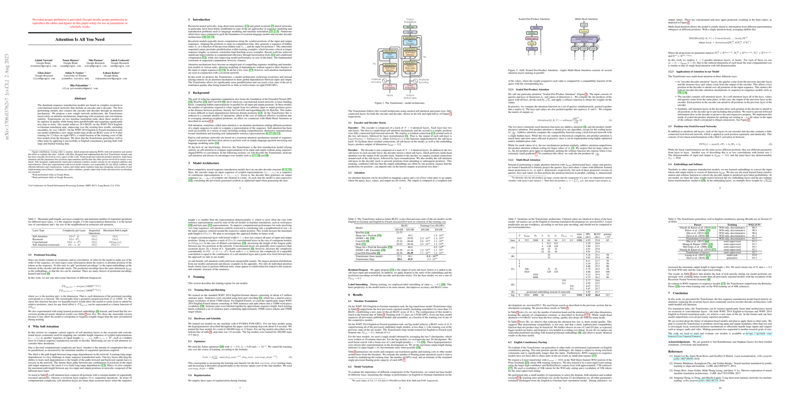

In [12]:
# Download and convert a sample PDF
# Using a sample academic paper
pdf_url = "https://arxiv.org/pdf/1706.03762"

# Limit to first 10 pages to manage token usage
images = get_pdf_images(pdf_url, dpi=144, max_pages=10)

# Display thumbnail grid
grid = create_image_grid(images, num_columns=5)
if grid:
    display(grid.resize((800, 400)))


In [13]:
# Ask a question about the document
prompt = "Please summarize the key contributions of this paper based on its abstract and introduction."

response = inference_with_images(images, prompt)
display(Markdown(response))


Sending 10 pages to the model...


Based on the abstract (image 0) and introduction (image 1), the key contributions of this paper are:

1.  **Proposing the Transformer**: The paper introduces a new neural network architecture called the Transformer, which is based *entirely* on attention mechanisms, dispensing with recurrence and convolutions that were dominant in previous models.
2.  **Achieving State-of-the-Art Performance**: The Transformer model achieves superior quality in machine translation tasks, specifically setting a new single-model state-of-the-art BLEU score of 41.8 on the WMT 2014 English-to-French task.
3.  **Significant Training Efficiency**: The model is more parallelizable and requires significantly less time to train. For example, it achieves top results on the English-to-German task after only 3.5 days of training on eight GPUs, which is a small fraction of the training cost of previous best models.
4.  **Generalization to Other Tasks**: The paper demonstrates that the Transformer generalizes well to other tasks, such as English constituency parsing, both with large and limited training data.
5.  **Motivating Self-Attention**: The paper provides a strong argument for using self-attention by comparing its computational complexity, parallelizability, and path length for learning long-range dependencies against recurrent and convolutional layers (discussed in Section 4, image 5).

In [14]:
# Ask another question
prompt = "What evaluation benchmarks are mentioned in this paper?"

response = inference_with_images(images, prompt)
display(Markdown(response))


Sending 10 pages to the model...


Based on the provided document, the evaluation benchmarks mentioned are:

1.  **Machine Translation:**
    *   **WMT 2014 English-to-German (EN-DE) translation task:** This is the primary benchmark for the main Transformer model evaluation, with results presented in Table 2 (image 7) and Table 3 (image 8).
    *   **WMT 2014 English-to-French (EN-FR) translation task:** This is another primary benchmark, with results also presented in Table 2 (image 7).

2.  **English Constituency Parsing:**
    *   **Wall Street Journal (WSJ) portion of the Penn Treebank:** This is used for evaluating the Transformer's generalization to other tasks. Results are presented in Table 4 (image 9) and discussed in Section 6.3 (image 8). The specific metric used is WSJ 23 F1.

The paper also mentions that training data for these tasks came from the WMT 2014 datasets (Section 5.1, image 6).

## Tips for Long Documents

1. **Limit pages**: Start with fewer pages to test, then increase
2. **DPI setting**: Lower DPI (e.g., 100) reduces token usage but may affect quality
3. **Focused questions**: Ask specific questions about sections rather than general summaries
4. **Chunking**: For very long documents, process in chunks and combine results
